In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
pd.set_option('display.max_columns', None)

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from math import sqrt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from math import sqrt

In [20]:
# df_meter is the output of the past function.  Decided to use dummy varaibles for the meters instead of exact values 
# in seperate columns.  I felt this was more condusive for the model 
df_meter = pd.read_csv('meter_dummies_final.csv')
df_building_meta = pd.read_csv('building_metadata.csv')

In [21]:
def prepare_knn_df(df_meter, df_building_meta):
    df_building_meta.drop(['year_built', 'floor_count', 'site_id'], axis=1, inplace=True)
    df_meter.drop('timestamp', axis = 1, inplace=True)
    building_mean = df_meter.groupby('building_id')['meter_reading'].mean()
    df_building_meta['mean_meter'] = building_mean
    df_building_meta['mean_meter'] = np.where(df_building_meta['mean_meter'] >= 25000, 25000, df_building_meta['mean_meter'])
    df_building_meta.drop(['building_id', 'primary_use'], axis=1, inplace=True)
    return df_building_meta

In [22]:
knn_df = prepare_knn_df(df_meter, df_building_meta)

In [28]:
def build_knn(knn_df):
    df_avg = knn_df[knn_df['mean_meter'] <= 250000]
    
    scaler = StandardScaler()
    scaler.fit(df_avg)
    scaled_features = scaler.transform(knn_df)
    
    df_feat = pd.DataFrame(scaled_features,columns=knn_df.columns)
    kmeans = KMeans()
    kmeans.fit(df_feat)
    
    return scaler, kmeans

In [29]:
scaler, kmeans = build_knn(knn_df)

In [33]:
def building_groups_knn(scaler, kmeans, knn_df):
    df_scaled_features = scaler.transform(knn_df)
    df_features = pd.DataFrame(df_scaled_features,columns=knn_df.columns)
    knn_df['building_groups'] = kmeans.predict(df_features)
    return knn_df

In [34]:
building_knn = building_groups_knn(scaler, kmeans, knn_df)

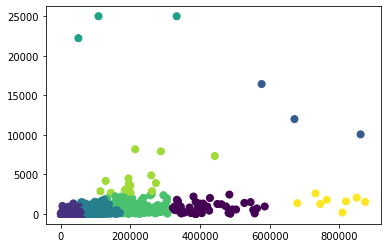

In [36]:
# optional to visualize knn 
# plt.scatter(building_knn['square_feet'], building_knn['mean_meter'], c=building_knn['building_groups'], s=50, cmap='viridis')

## Final Model DF 

In [37]:
# re import the original building metadata 
building = pd.read_csv('building_metadata.csv')


In [38]:
def combine_dfs(building, df_meter, building_knn): 
    model_df = pd.merge(building, df_meter)
    #creates dummies for primary use category 
    model_df = pd.concat([model_df, pd.get_dummies(model_df['primary_use'])], axis=1)
    model_df.drop('primary_use', axis = 1, inplace=True)
    model_df = pd.merge(model_df, building_knn)
    model_df.drop(['site_id', 'building_id', 'year_built', 'floor_count', 'meter', 'mean_meter'], axis=1, inplace=True)
    model_df.drop_duplicates(inplace=True)
    return model_df 
    

In [40]:
final_model = combine_dfs(building, df_meter, building_knn)

### Random Forrest 

In [52]:
def rf_model(final_model):
    scaler_model = StandardScaler()
    train = final_model.drop('meter_reading', axis=1)
    test = final_model['meter_reading']
    scaler_model.fit(train)
    train = scaler_model.transform(train)
    
    X_train, X_test, y_train, y_test = train_test_split(train, test, test_size=0.2, random_state=42)
    rf = RandomForestRegressor()
    rf.fit(X_train, y_train)
    predictions = rf.predict(X_test)
    
    meanSquaredError = mean_squared_error(y_test, predictions)
    print("MSE:", meanSquaredError)
    rootMeanSquaredError = sqrt(meanSquaredError)
    print("RMSE:", rootMeanSquaredError)
    
    return rf

In [51]:
# sample of only 100k rows.  The below results probably aren't accurate because it is a sample of a sample 
forrest_model = rf_model(final_model)

/Users/eric/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


MSE: 67.97652108856492
RMSE: 8.244787510213039
